# Scenarios, Numerical integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy import stats
from scipy import optimize
from scipy import integrate
from scipy import misc

from tqdm.notebook import tqdm
import timeit

### Best response functions & Utilities

In [2]:
def BR_OPTIMIZE_f(v,rv) :
    """
    Using optimize.minimize, it returns the best response function against the NON-NEGATIVE random variable rv :
    v \mapsto argmax_b (v-b)G(b)
    where G is the cdf of rv
    """
    minus_utility_v = lambda b : -(v-b)*rv.cdf(b)
    opt = optimize.minimize_scalar(minus_utility_v,method="bounded",bracket=(0,1),bounds=(0,1))
    return opt.x

In [3]:
def array_to_f(x,x_,y_) :
    return y_[min(np.searchsorted(x_,x),len(x_)-1)]

In [5]:
def array_to_inverse_f(y,x_,y_) :
    return x_[min(np.searchsorted(y_,y),len(y_)-1)]

In [6]:
def f_to_array(f,x_,) :
    return np.array([f(x) for x in x_])

### Marshall methods

In [7]:
def marshall1_sub_method(tstar,k1,k2,N=10_000,p=5,correct=True) :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1'] = l1
    output['l2'] = l2
    output['k1'] = k1
    output['k2'] = k2
    
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)

    a_ = np.zeros(p+1)
    b_ = np.zeros(p+1)
    
    delta1_[N+1] = 1/tstar
    delta2_[N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
                    
        #values at tj, equation (17)
        a_[0] = delta1_[j] 
        b_[0] = delta2_[j]
        
        ## updating the Taylors approximations astar_,bstar_ equations (19, 20)
        
        for l in range(p) :
            sum1 = np.sum([i*b_[l+1-i]*( a_[i-1]+tj*a_[i]) for i in range(1,l+1)])
            sum2 = np.sum([i*a_[l+1-i]*( b_[i-1]+tj*b_[i]) for i in range(1,l+1)])
    
            a_[l+1] = 1/((l+1)*(b_[0]-1)*tj) * ( (1/k1-(l+1)*(b_[0]-1))*a_[l]-sum1 )
            b_[l+1] = 1/((l+1)*(a_[0]-1)*tj) * ( (1/k2-(l+1)*(a_[0]-1))*b_[l]-sum2 )
        
        tjm1 = tstar*(j-1)/(N+1)
            
        delta1_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,a_) #updating at tj-1
        delta2_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,b_)
        
        if(output['breakpoint'] == 0 and ((delta1_[j-1]-l1)**2+(delta2_[j-1]-l2)**2 > ((delta1_[j]-l1)**2+(delta2_[j]-l2)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
    
    output['eps_star'] = np.sqrt(((delta1_[output['breakpoint']]-l1)**2+(delta2_[output['breakpoint']]-l2)**2))
    #output['precision'] = np.min(((delta1_-l1)**2+(delta2_-l2)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        
        #patch_ = 1/(np.linspace(0,out['tstar'],out['N']+2)[1:])
        #delta1_[1:] = np.where(delta1_[1:] > patch_, patch_,delta1_[1:])
        #delta2_[1:] = np.where(delta2_[1:] > patch_, patch_,delta2_[1:])
        
    output['delta1_']=delta1_
    output['delta2_']=delta2_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    return output

In [8]:
def marshall1_close_form_boundary(k1,k2,N=10_000,p=5,correct=True) :
    tstar = k1/(k1+1)
    
    if(k1!=k2) :
        tstar = 1-np.power(1+k1,k2/(k1-k2))/np.power(1+k2,k1/(k1-k2))*np.power((k2*(1+k1))/(k1*(1+k2)),k1*k2/(k1-k2))
        
    return marshall1_sub_method(tstar,k1,k2,N=N,p=p,correct=correct)

In [9]:
def marshall2_sub_method(tstar,k1,k2,N=10_000,p=5,correct=True) :
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)
    
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['k1'] = k1
    output['k2'] = k2
    output['breakpoint'] = 0
    output['l1'] = l1
    output['l2'] = l2
    
    a_ = np.zeros(p+1)
    b_ = np.zeros(p+1)
    c_ = np.zeros(p+1)
    alpha_ = np.zeros(p+1)
    beta_ = np.zeros(p+1)
    gamma_ = np.zeros(p+1)
    
    theta = (k2-1)/k1
    
    delta1_[N+1] = 1/tstar
    delta2_[N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
                    
        #values at tj, equations (17 (modified, see 26), 36, 37)
        b_[0] = delta2_[j]
        
        #c_[0] = (delta1_[j]**(k1/(k1+k2-1)))*(delta2_[j]**((k2-1)/(k1+k2-1)))
        #a_[0] = c_[0]*(c_[0]/b_[0])**theta
        
        a_[0] = delta1_[j]
        c_[0] = (a_[0]**(k1/(k1+k2-1)))*(b_[0]**((k2-1)/(k1+k2-1)))
        
        alpha_[0] = a_[0]*c_[0]
        beta_[0] = b_[0]*c_[0]
        gamma_[0] = a_[0]*b_[0]
        
        ## updating the Taylors approximations equations (16, 33, 34, 35)
        for l in range(p) :
            sum_b = np.sum([i*a_[l+1-i]*( b_[i-1]+tj*b_[i]) for i in range(1,l+1)])    
            b_[l+1] = -b_[l]/tj + 1/((l+1)*(a_[0]-1)*tj) * ( (1/k2)*b_[l]-sum_b )
        
            sum_c = np.sum([i*b_[l+1-i]*( c_[i-1]+tj*c_[i]) for i in range(1,l+1)])
            c_[l+1] = -c_[l]/tj + 1/((l+1)*(b_[0]-1)*tj) * ( (1/(k1+k2-1))*c_[l]-sum_c )
            
            A = np.sum([i*c_[i]*gamma_[l+1-i]-a_[i]*beta_[l+1-i] for i in range(1,l+1)]) 
            B = theta*np.sum([i*c_[i]*gamma_[l+1-i]-b_[i]*alpha_[l+1-i] for i in range(1,l+1)])
            a_[l+1] = c_[l+1]*alpha_[0]/beta_[0]+theta*(c_[l+1]*alpha_[0]/beta_[0]-b_[l+1]*alpha_[0]/beta_[0])+1/((l+1)*beta_[0]) * (A+B)
            
            alpha_[l+1] = np.sum([a_[i]*c_[l+1-i] for i in range(0,l+2)]) 
            beta_[l+1] = np.sum([b_[i]*c_[l+1-i] for i in range(0,l+2)]) 
            gamma_[l+1] = np.sum([a_[i]*b_[l+1-i] for i in range(0,l+2)]) 
        
        tjm1 = tstar*(j-1)/(N+1)
        
        delta1_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,a_) #updating at tj-1
        delta2_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,b_)
        
        if(output['breakpoint'] == 0 and ((delta1_[j-1]-l1)**2+(delta2_[j-1]-l2)**2 > ((delta1_[j]-l1)**2+(delta2_[j]-l2)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
    
    output['eps_star'] = np.sqrt(((delta1_[output['breakpoint']]-l1)**2+(delta2_[output['breakpoint']]-l2)**2))
    #output['precision'] = np.min(((delta1_-l1)**2+(delta2_-l2)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        
        #patch_ = 1/(np.linspace(0,out['tstar'],out['N']+2)[1:])
        #delta1_[1:] = np.where(delta1_[1:] > patch_, patch_,delta1_[1:])
        #delta2_[1:] = np.where(delta2_[1:] > patch_, patch_,delta2_[1:])
        
    output['delta1_']=delta1_
    output['delta2_']=delta2_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    return output

In [10]:
def marshall2_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,nb_eval_max=500,N=10_000,p=5,show_msg=False) :
    l1 = 1+1/k2
    l2 = 1+1/(k1+k2-1)
    
    a = 1/l1
    b = 1/l2
    
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = marshall2_sub_method(x_1,k1,k2,N,p,correct=True)
    
    x_2 = a + tau*(b-a)
    f_2 = marshall2_sub_method(x_2,k1,k2,N,p,correct=True)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = marshall2_sub_method(x_2,k1,k2,N,p,correct=True)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = marshall2_sub_method(x_1,k1,k2,N,p,correct=True)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
    if(f_1['eps_star']<f_2['eps_star']) :
        return f_1
    else :
        return f_2

### Scenarios

In [11]:
def scenario1(k,n) :
    """
    The marketplace is bidding second highest report, a countercoallition is playing strategically
    """
    N=10_000
    v_ = np.linspace(0,1,N+1)
    
    RV = stats.beta(a=k-1,b=2)# F^k_(2)
    br_ = f_to_array(lambda v:BR_OPTIMIZE_f(v,RV), v_)
    
    beta_out = lambda v:array_to_f(v,v_,br_)
    beta_out_inverse = lambda b:array_to_inverse_f(b,v_,br_)
        
    integrand_in = lambda v2,v1: (v1-v2)*((beta_out_inverse(v2))**(n-k))*k*(k-1)*1*1*v2**(k-2)
    integrand_out = lambda v : (v-beta_out(v))*RV.cdf(beta_out(v))*((n-k)*v**(n-k-1))
    integrand_auct = lambda v: v*(beta_out_inverse(v))**(n-k)*RV.pdf(v)+beta_out(v)*RV.cdf(beta_out(v))*(n-k)*(v**(n-k-1))
    
    output = {}
    
    # Outer integral : x=v1
    # Inner integral : y=v2
    output['in'] = integrate.dblquad(integrand_in, 0, 1, lambda x:0, lambda x:x,epsabs=10**-10,epsrel=10**-10)[0]/k
    output['out'] = integrate.quad(integrand_out,0,1,limit=1000, epsabs=10**-10,epsrel=10**-10)[0]/(n-k)
    output['auct'] = integrate.quad(integrand_auct,0,1,limit=1000, epsabs=10**-10,epsrel=10**-10)[0]
    
    return output

In [12]:
def scenario2(k,n,N=10_000) :
    """
    The marketplace is playing against a coutercoallition, both plays strategically the NE
    """
    
    out = marshall1_close_form_boundary(k,n-k,N=N)
    b_ = np.linspace(0,out['tstar'],N+2)
    
    
    v_in_f = lambda b:array_to_f(b,b_,out['values1_'])
    v_out_f = lambda b:array_to_f(b,b_,out['values2_'])
    b_in_f = lambda v:array_to_inverse_f(v,b_,out['values1_'])
    b_out_f = lambda v:array_to_inverse_f(v,b_,out['values2_'])
    
    
    integrand_in = lambda v : (v-b_in_f(v))*(v_out_f(b_in_f(v))**(n-k))*k*v**(k-1)
    integrand_out = lambda v : (v-b_out_f(v))*((v_in_f(b_out_f(v)))**k)*((n-k)*v**(n-k-1))
    integrand_auct = lambda v : b_in_f(v)*((v_out_f(b_in_f(v)))**(n-k))*k*v**(k-1) + b_out_f(v)*((v_in_f(b_out_f(v)))**k)*(n-k)*v**(n-k-1)
    
    output = {}
    
    output['in'] = integrate.quad(integrand_in, 0, 1,limit=1000, epsabs=10**-10,epsrel=10**-10)[0]/k
    output['out'] = integrate.quad(integrand_out,0,1,limit=1000, epsabs=10**-10,epsrel=10**-10)[0]/(n-k)
    output['auct'] = integrate.quad(integrand_auct,0,1,limit=1000, epsabs=10**-10,epsrel=10**-10)[0]
    
    return output

In [13]:
def scenario3(k,n,N=10_000,eps=10**-3) :
    """
    The marketplace is playing against individuals, each player is strategic and plays NE
    """
    
    out = marshall2_iterative_find_boundary_CUSTOM(k,n-k,N=N,eps=eps)
    b_ = np.linspace(0,out['tstar'],N+2)
    
    
    v_in_f = lambda b:array_to_f(b,b_,out['values1_'])
    v_out_f = lambda b:array_to_f(b,b_,out['values2_'])
    b_in_f = lambda v:array_to_inverse_f(v,b_,out['values1_'])
    b_out_f = lambda v:array_to_inverse_f(v,b_,out['values2_'])
    
    
    integrand_in = lambda v : (v-b_in_f(v))*(v_out_f(b_in_f(v))**(n-k))*k*v**(k-1)
    integrand_out = lambda v : (v-b_out_f(v))*(v_in_f(b_out_f(v))**k)*((n-k)*v**(n-k-1))
    integrand_auct = lambda v : b_in_f(v)*((v_out_f(b_in_f(v)))**(n-k))*k*v**(k-1) + b_out_f(v)*((v_in_f(b_out_f(v)))**k)*(n-k)*v**(n-k-1)
    
    output = {}
    
    output['in'] = integrate.quad(integrand_in, 0, 1, limit=1000, epsabs=10**-10,epsrel=10**-10)[0]/k
    output['out'] = integrate.quad(integrand_out,0,1, limit=1000, epsabs=10**-10,epsrel=10**-10)[0]/(n-k)
    output['auct'] = integrate.quad(integrand_auct,0,1, limit=1000, epsabs=10**-10,epsrel=10**-10)[0]
    
    return output

## Tests

In [462]:
n = 20
k_ = np.arange(1,n)

#scenarios_[n] = {}

for k in tqdm(k_) :   
    
    scenarios_[n][k] = {1:{}, 2:{}, 3:{}}
    
    output = scenario1(k,n)
    scenarios_[n][k][1]['auct'] = output['auct']
    scenarios_[n][k][1]['in'] = output['in']
    scenarios_[n][k][1]['out'] = output['out']
    
    output = scenario2(k,n)
    scenarios_[n][k][2]['auct'] = output['auct']
    scenarios_[n][k][2]['in'] = output['in']
    scenarios_[n][k][2]['out'] = output['out']
        
    output = scenario3(k,n,eps=10**-6)
    scenarios_[n][k][3]['auct'] = output['auct']
    scenarios_[n][k][3]['in'] = output['in']
    scenarios_[n][k][3]['out'] = output['out']

/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/m.hihat/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


In [467]:
#pickle.dump(scenarios_,open( "scenarios_.pickle", "wb" ))

In [14]:
#scenarios_ = pickle.load(open( "scenarios_.pickle", "rb" ))

In [23]:
n = 20; k_ = np.arange(1,n)

print("Coalition vs Individuals, n =", n)
for k in k_ :
    print("k {} | in {:.6f} | out {:.6f} | 1/(k+1) {:.3f}".format(k,scenarios_[n][k][3]['in'],scenarios_[n][k][3]['out'],1/(k+1)))

Coalition vs Individuals, n = 20
k 1 | in 0.002381 | out 0.002379 | 1/(k+1) 0.500
k 2 | in 0.002385 | out 0.002392 | 1/(k+1) 0.333
k 3 | in 0.002397 | out 0.002420 | 1/(k+1) 0.250
k 4 | in 0.002420 | out 0.002466 | 1/(k+1) 0.200
k 5 | in 0.002453 | out 0.002532 | 1/(k+1) 0.167
k 6 | in 0.002499 | out 0.002622 | 1/(k+1) 0.143
k 7 | in 0.002561 | out 0.002741 | 1/(k+1) 0.125
k 8 | in 0.002641 | out 0.002897 | 1/(k+1) 0.111
k 9 | in 0.002743 | out 0.003099 | 1/(k+1) 0.100
k 10 | in 0.002873 | out 0.003362 | 1/(k+1) 0.091
k 11 | in 0.003038 | out 0.003709 | 1/(k+1) 0.083
k 12 | in 0.003248 | out 0.004173 | 1/(k+1) 0.077
k 13 | in 0.003522 | out 0.004812 | 1/(k+1) 0.071
k 14 | in 0.003886 | out 0.005725 | 1/(k+1) 0.067
k 15 | in 0.004386 | out 0.007099 | 1/(k+1) 0.062
k 16 | in 0.005110 | out 0.009334 | 1/(k+1) 0.059
k 17 | in 0.006238 | out 0.013416 | 1/(k+1) 0.056
k 18 | in 0.008237 | out 0.022508 | 1/(k+1) 0.053
k 19 | in 0.012815 | out 0.053897 | 1/(k+1) 0.050


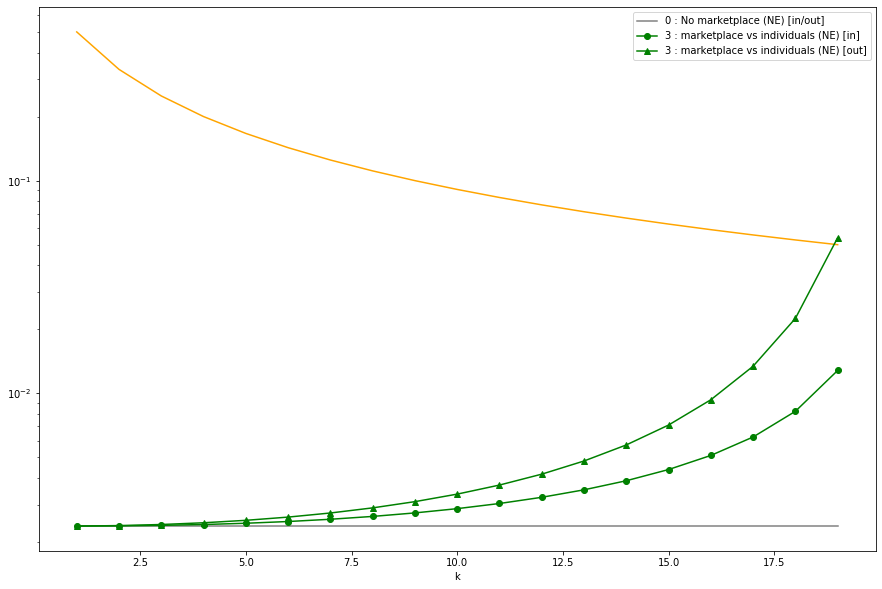

In [25]:
n=20; k_ = np.arange(1,n)
plt.figure(figsize=(15,10))
plt.xlabel("k")

plt.semilogy(k_,0*k_+1/(n*(n+1)),'-',color='gray',label="0 : No marketplace (NE) [in/out]")

plt.semilogy(k_,1/(k_+1),'-',color='orange')

#plt.semilogy(k_,[scenarios_[n][k][1]['in'] for k in k_],'-o',color='red',label=r"1 : $r_{(2)}$ marketplace vs countercoallition [in]")
#plt.semilogy(k_,[scenarios_[n][k][2]['in'] for k in k_],'-o',color='blue',label=r"2 : marketplace vs countercoallition (NE) [in]")
plt.semilogy(k_,[scenarios_[n][k][3]['in'] for k in k_],'-o',color='green',label=r"3 : marketplace vs individuals (NE) [in]")

#plt.semilogy(k_,[scenarios_[n][k][1]['out'] for k in k_],'-^',color='red',label=r"1 : $r_{(2)}$ marketplace vs countercoallition [out]")
#plt.semilogy(k_,[scenarios_[n][k][2]['out'] for k in k_],'-^',color='blue',label=r"2 : marketplace vs countercoallition (NE) [out]")
plt.semilogy(k_,[scenarios_[n][k][3]['out'] for k in k_],'-^',color='green',label=r"3 : marketplace vs individuals (NE) [out]")


#plt.semilogy(k_,0*k_+(n-1)/(n+1),'-',color='gray',label="0 : No marketplace (NE) [auct]")

#plt.semilogy(k_,[scenarios_[n][k][1]['auct'] for k in k_],'-+',color='red',label=r"1 : $r_{(2)}$ marketplace vs countercoallition [auct]")
#plt.semilogy(k_,[scenarios_[n][k][2]['auct'] for k in k_],'-+',color='blue',label=r"2 : marketplace vs countercoallition (NE) [auct]")
#plt.semilogy(k_,[scenarios_[n][k][3]['auct'] for k in k_],'-+',color='green',label=r"3 : marketplace vs individuals (NE) [auct]")

plt.legend()
plt.show()

### Garbage

In [363]:
n=4; k=3; k1 = k; k2=n-k;

out = marshall2_iterative_find_boundary_CUSTOM(k1,k2,N=10_000,eps=10**-3)
display2(out)

dx = 10**-3
b_ = np.linspace(0,out['tstar'],out['N']+2)

delta1_f = lambda b:array_to_f(b,b_,out['delta1_'])
delta2_f = lambda b:array_to_f(b,b_,out['delta2_'])
lambda1_f = lambda b:array_to_f(b,b_,out['values1_'])
lambda2_f = lambda b:array_to_f(b,b_,out['values2_'])

b_ok = np.linspace(dx,out['tstar']-dx,1001)

delta1_fprime = lambda b:misc.derivative(delta1_f,b,dx=dx)
delta2_fprime = lambda b:misc.derivative(delta2_f,b,dx=dx)

equation_10 = lambda t: np.abs(k2*(delta1_f(t)-1)*(delta2_f(t)+t*delta2_fprime(t))-delta2_f(t))

lambda1_fprime = lambda b:misc.derivative(lambda1_f,b,dx=dx)
lambda2_fprime = lambda b:misc.derivative(lambda2_f,b,dx=dx)

equation_2 = lambda t: np.abs(k2*(lambda1_f(t)-t)*lambda2_fprime(t)-lambda2_f(t))

plt.figure(figsize=(20,10))
plt.semilogy(b_ok,[equation_10(b) for b in b_ok],'r')
plt.semilogy(b_ok,[equation_2(b) for b in b_ok],'b')
plt.axhline(10**-2,color='k')
plt.axhline(10**-3,color='k')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(b_ok,[delta1_f(b) for b in b_ok],'k',linewidth=1)
for b in np.linspace(0.05,0.6,20) :
    plt.plot(b+np.linspace(-10**-2,10**-2,3),delta1_f(b)+np.linspace(-10**-2,10**-2,3)*delta1_fprime(b),'-x',linewidth=3)
plt.xlim((0.4,0.6))
plt.show()

KeyboardInterrupt: 